In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
from google.colab import drive
print(tf.__version__)

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

2.5.0


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Edge/
!ls

/content/drive/MyDrive/Edge
BIPED  DexiNed.h5


In [4]:
train_path = "./BIPED/edges/imgs/train/rgbr/real/*"
edge_train_path = "./BIPED/edges/edge_maps/train/rgbr/real/*"
test_path = "./BIPED/edges/imgs/test/rgbr/*"
edge_test_path = "./BIPED/edges/edge_maps/test/rgbr/*"

In [5]:
def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

In [6]:
images, edges = load_data(train_path, edge_train_path)
testimg, testedg = load_data(test_path, edge_test_path)

In [7]:
print(len(images), len(edges))

200 200


In [49]:
def read_image(path, H=720, W=1280):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=720, W=1280):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, x = cv2.threshold(x,127,255,cv2.THRESH_BINARY)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [50]:
def preprocess(x,y,H=720, W=1280):
    
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        x = read_image(x)
        y = read_edge(y)
        return x, y
    
    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

In [51]:
def tf_data(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=10)
    data = data.map(preprocess)
    data = data.batch(1)
    data = data.prefetch(1)
    return data

In [52]:
train_data = tf_data(images, edges)
test_data = tf_data(testimg, testedg)

In [53]:
for x, y in train_data:
    print(x.shape, y.shape)
print(train_data)

(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1280, 1)
(1, 720, 1280, 3) (1, 720, 1

In [54]:
weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.l2
w_decay=1e-3

In [55]:
def double_conv_block(inputs, f1, f2, stride=(1,1), act=True):
    
    k_reg = None if w_decay is None else l2(w_decay)
    
    c1 = Conv2D(filters=f1, kernel_size=(3,3), strides=stride, padding="same", kernel_initializer=weight_init, kernel_regularizer=k_reg)(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer=weight_init, kernel_regularizer=k_reg)(c1)
    c1 = BatchNormalization()(c1)
    
    if act:
        c1 = Activation("relu")(c1)
    
    return c1

In [56]:
def DenseBlock(inputs, filters):
    
    k_reg = None if w_decay is None else l2(w_decay)
    
    c1 = Activation("relu")(inputs)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=weight_init, kernel_regularizer=k_reg)(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation("relu")(c1)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=weight_init, kernel_regularizer=k_reg)(c1)
    c1 = BatchNormalization()(c1)
    
    return c1

In [57]:
def single_conv_block(inputs, filters, kernel=(1,1), strides=(1,1), bn=False, act=False, w_init=None):
    
    k_reg = None if w_decay is None else l2(w_decay)
    
    c1 = Conv2D(filters=filters, kernel_size=kernel, strides=strides, padding="same", kernel_initializer=w_init, kernel_regularizer=k_reg)(inputs)
    
    if bn:
        c1 = BatchNormalization()(c1)
        
    if act:
        c1 = Activation("relu")(c1)
        
    return c1

In [58]:
def UpConvBlock(inputs, up_scale):
    
    constant_features = 16
    k_reg = None if w_decay is None else l2(w_decay)
    c1 = inputs
    
    total_up_scale = 2 ** up_scale
    
    for i in range(up_scale):
        
        filters = 1 if i == up_scale-1 else constant_features
        
        if i==up_scale-1:
            
            c1 = Conv2D(filters=filters, kernel_size=(1,1), 
                        strides=(1,1), padding='same', activation='relu', 
                        kernel_initializer=tf.initializers.TruncatedNormal(mean=0.),kernel_regularizer=k_reg)(c1)
            c1 = Conv2DTranspose(filters, kernel_size=(total_up_scale,total_up_scale), 
                                 strides=(2,2), padding='same', kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.1), 
                                 kernel_regularizer=k_reg)(c1)
        else:
            
            c1 = Conv2D(filters=filters, kernel_size=(1,1), 
                        strides=(1,1), padding='same', activation='relu', 
                        kernel_initializer=tf.initializers.TruncatedNormal(mean=0.),kernel_regularizer=k_reg)(c1)
            c1 = Conv2DTranspose(filters, kernel_size=(total_up_scale,total_up_scale), strides=(2,2), padding='same',
                                kernel_initializer=weight_init, kernel_regularizer=k_reg)(c1)
            
    
    
    return c1   

In [59]:
def build_model():
    
    inputs = Input((720, 1280,3))
    
    b1 = double_conv_block(inputs, 32, 64, stride=(2,2), act=False)
    side_b1 = single_conv_block(b1, 128, strides=(2,2), bn=True, w_init=weight_init)
    
    b2 = double_conv_block(b1, 128, 128, act=False)
    b2 = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(b2)
    b2_up = Concatenate()([b2 + side_b1])
    side_b2 = single_conv_block(b2_up, 256, strides=(2,2), bn=True, w_init=weight_init)
    
    b3_pre = single_conv_block(b2, 128, strides=(1,1), bn=True, w_init=weight_init)
    b3 = DenseBlock(b2_up+b3_pre, 256)
    b3 = DenseBlock(b3, 256)
    b3_down = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(b3)
    b3_add = b3_down + side_b2
    side_b3 = single_conv_block(b3_add, 512, strides=(2,2), bn=True, w_init=weight_init)
    
    b4_pre_1 = single_conv_block(b2, 256, strides=(2,2), w_init=weight_init)
    b4_pre_2 = single_conv_block(b3_down+b4_pre_1, 256, strides=(1,1), bn=True, w_init=weight_init)
    b4 = DenseBlock(b3_add+b4_pre_2, 512)
    b4 = DenseBlock(b4, 512)
    b4 = DenseBlock(b4, 512)
    b4_down = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(b4)
    b4_add = b4_down+side_b3
    side_b4 = single_conv_block(b4_add, 512, strides=(1,1), bn=True, w_init=weight_init)
    
    b5_pre_1 = single_conv_block(b4_pre_1, 512, strides=(2,2), w_init=weight_init)
    b5_pre_2 = single_conv_block(b4_down+b5_pre_1, 512, strides=(1,1), bn=True, w_init=weight_init)
    b5 = DenseBlock(b4_add+b5_pre_2, 512)
    b5 = DenseBlock(b5, 512)
    b5 = DenseBlock(b5, 512)
    b5_add = b5+side_b4
    
    b6_pre = single_conv_block(b5, 512, strides=(1,1), bn=True, w_init=weight_init)
    b6 = DenseBlock(b5_add+b6_pre, 256)
    b6 = DenseBlock(b6, 256)
    b6 = DenseBlock(b6, 256)
    
    out1 = UpConvBlock(b1, 1)
    out2 = UpConvBlock(b2, 2)
    out3 = UpConvBlock(b3, 2)
    out4 = UpConvBlock(b4, 3)
    out5 = UpConvBlock(b5, 4)
    out6 = UpConvBlock(b6, 4)
    results = [out1, out2, out3, out4, out5, out6]
    
    block_cat = Concatenate()([out1,out2,out3,out4,out5,out6])
    b1_cat = single_conv_block(block_cat, 3, strides=(1,1), bn=True, w_init=tf.constant_initializer(1/5))
    bl = Concatenate()([block_cat, b1_cat])
    bl = Conv2D(1, kernel_size=(3,3), padding="same")(bl)
    bl = Activation("sigmoid")(bl)

    return Model(inputs=inputs, outputs=bl)

In [60]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 1280, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 360, 640, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 360, 640, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 360, 640, 64) 18496       batch_normalization[0][0]        
______________________________________________________________________________________________

In [63]:
model.compile(
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.FalseNegatives(), 
             tf.keras.metrics.FalsePositives(), 
             tf.keras.metrics.TruePositives(), 
             tf.keras.metrics.TrueNegatives()])

In [64]:
train_steps=len(train_data)
val_steps=len(test_data)
print(train_steps)
model.fit(train_data, validation_data=test_data, epochs=20, steps_per_epoch=train_steps, validation_steps=val_steps)

200
Epoch 1/20
200/200 [==============================] - 146s 697ms/step - loss: 0.1815 - binary_accuracy: 0.9697 - false_negatives_1: 5318489.0000 - false_positives_1: 274404.0000 - true_positives_1: 92265.0000 - true_negatives_1: 178634848.0000 - val_loss: 0.2168 - val_binary_accuracy: 0.9674 - val_false_negatives_1: 1501545.0000 - val_false_positives_1: 14.0000 - val_true_positives_1: 10.0000 - val_true_negatives_1: 44578440.0000
Epoch 2/20
200/200 [==============================] - 137s 687ms/step - loss: 0.1534 - binary_accuracy: 0.9696 - false_negatives_1: 5331454.0000 - false_positives_1: 272649.0000 - true_positives_1: 79300.0000 - true_negatives_1: 178636560.0000 - val_loss: 0.1473 - val_binary_accuracy: 0.9673 - val_false_negatives_1: 1500514.0000 - val_false_positives_1: 5715.0000 - val_true_positives_1: 1041.0000 - val_true_negatives_1: 44572732.0000
Epoch 3/20
200/200 [==============================] - 138s 688ms/step - loss: 0.1355 - binary_accuracy: 0.9696 - false_negat

In [65]:
model.save('./DexiNed.h5')

In [66]:
img = read_image('./BIPED/edges/edge_maps/test/rgbr/RGB_008.png')
img = np.expand_dims(img, axis=0)

In [74]:
res = model.predict(img)

In [75]:
print(res.shape)
res = res[-1,:,:]
print(res.shape)

(1, 720, 1280, 1)
(720, 1280, 1)


In [76]:
res = res[:,:,-1]
print(res.shape)

(720, 1280)


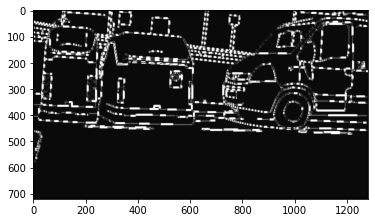

In [77]:
plt.imshow(res, cmap="gray")
plt.show()

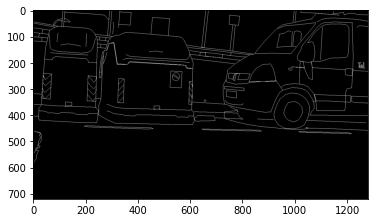

In [78]:
img = read_image('./BIPED/edges/edge_maps/test/rgbr/RGB_008.png')
plt.imshow(img)